In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Define the fitting models

In [2]:
# Define the logistic growth rate model
def area_logistic(t, a0, r, k):
    """
    Logistic growth function
    -------------------------
    t  : Time
    a0 : Area at time zer0
    r  : Growth rate
    k  : Carrying capacity
    """
    return k / (1 + (k/a0 - 1)*np.exp(-r*t))

def der1_area_logistic(t, a0, r, k):
    A = k / (1 + (k/a0 - 1)*np.exp(-r*t))
    return r*A*(1-A/k)

def der2_area_logistic(t, a0, r, k):
    A  = k / (1 + (k/a0 - 1)*np.exp(-r*t))
    Ak = A/k
    return (r**2)*A*(1-Ak)*(1-2*Ak)

# Define the Richards logistic growth rate model
def area_Rlogistic(t, a0, r, k, u):
    """
    Generalised logistic function (Richard's curve)
    -----------------------------------------------
    t  : Time
    a0 : Area at time zer0
    r  : Growth rate
    k  : Carrying capacity
    u  : Affects near which asymptote maximum growth occurs
    """
    return k / (1 + ((k/a0)**u - 1)*np.exp(-r*u*t))**(1/u)

def der1_area_Rlogistic(t, a0, r, k, u):
    A = k / (1 + ((k/a0)**u - 1)*np.exp(-r*u*t))**(1/u)
    return r*A*(1-(A/k)**u)

def der2_area_Rlogistic(t, a0, r, k, u):
    A   = k / (1 + ((k/a0)**u - 1)*np.exp(-r*u*t))**(1/u)
    Aku = (A/k)**u
    return (r**2)*A*(1-Aku)*(1-(1+u)*Aku)

### Read the data frame and show a summary of the growth curves and the fitting models

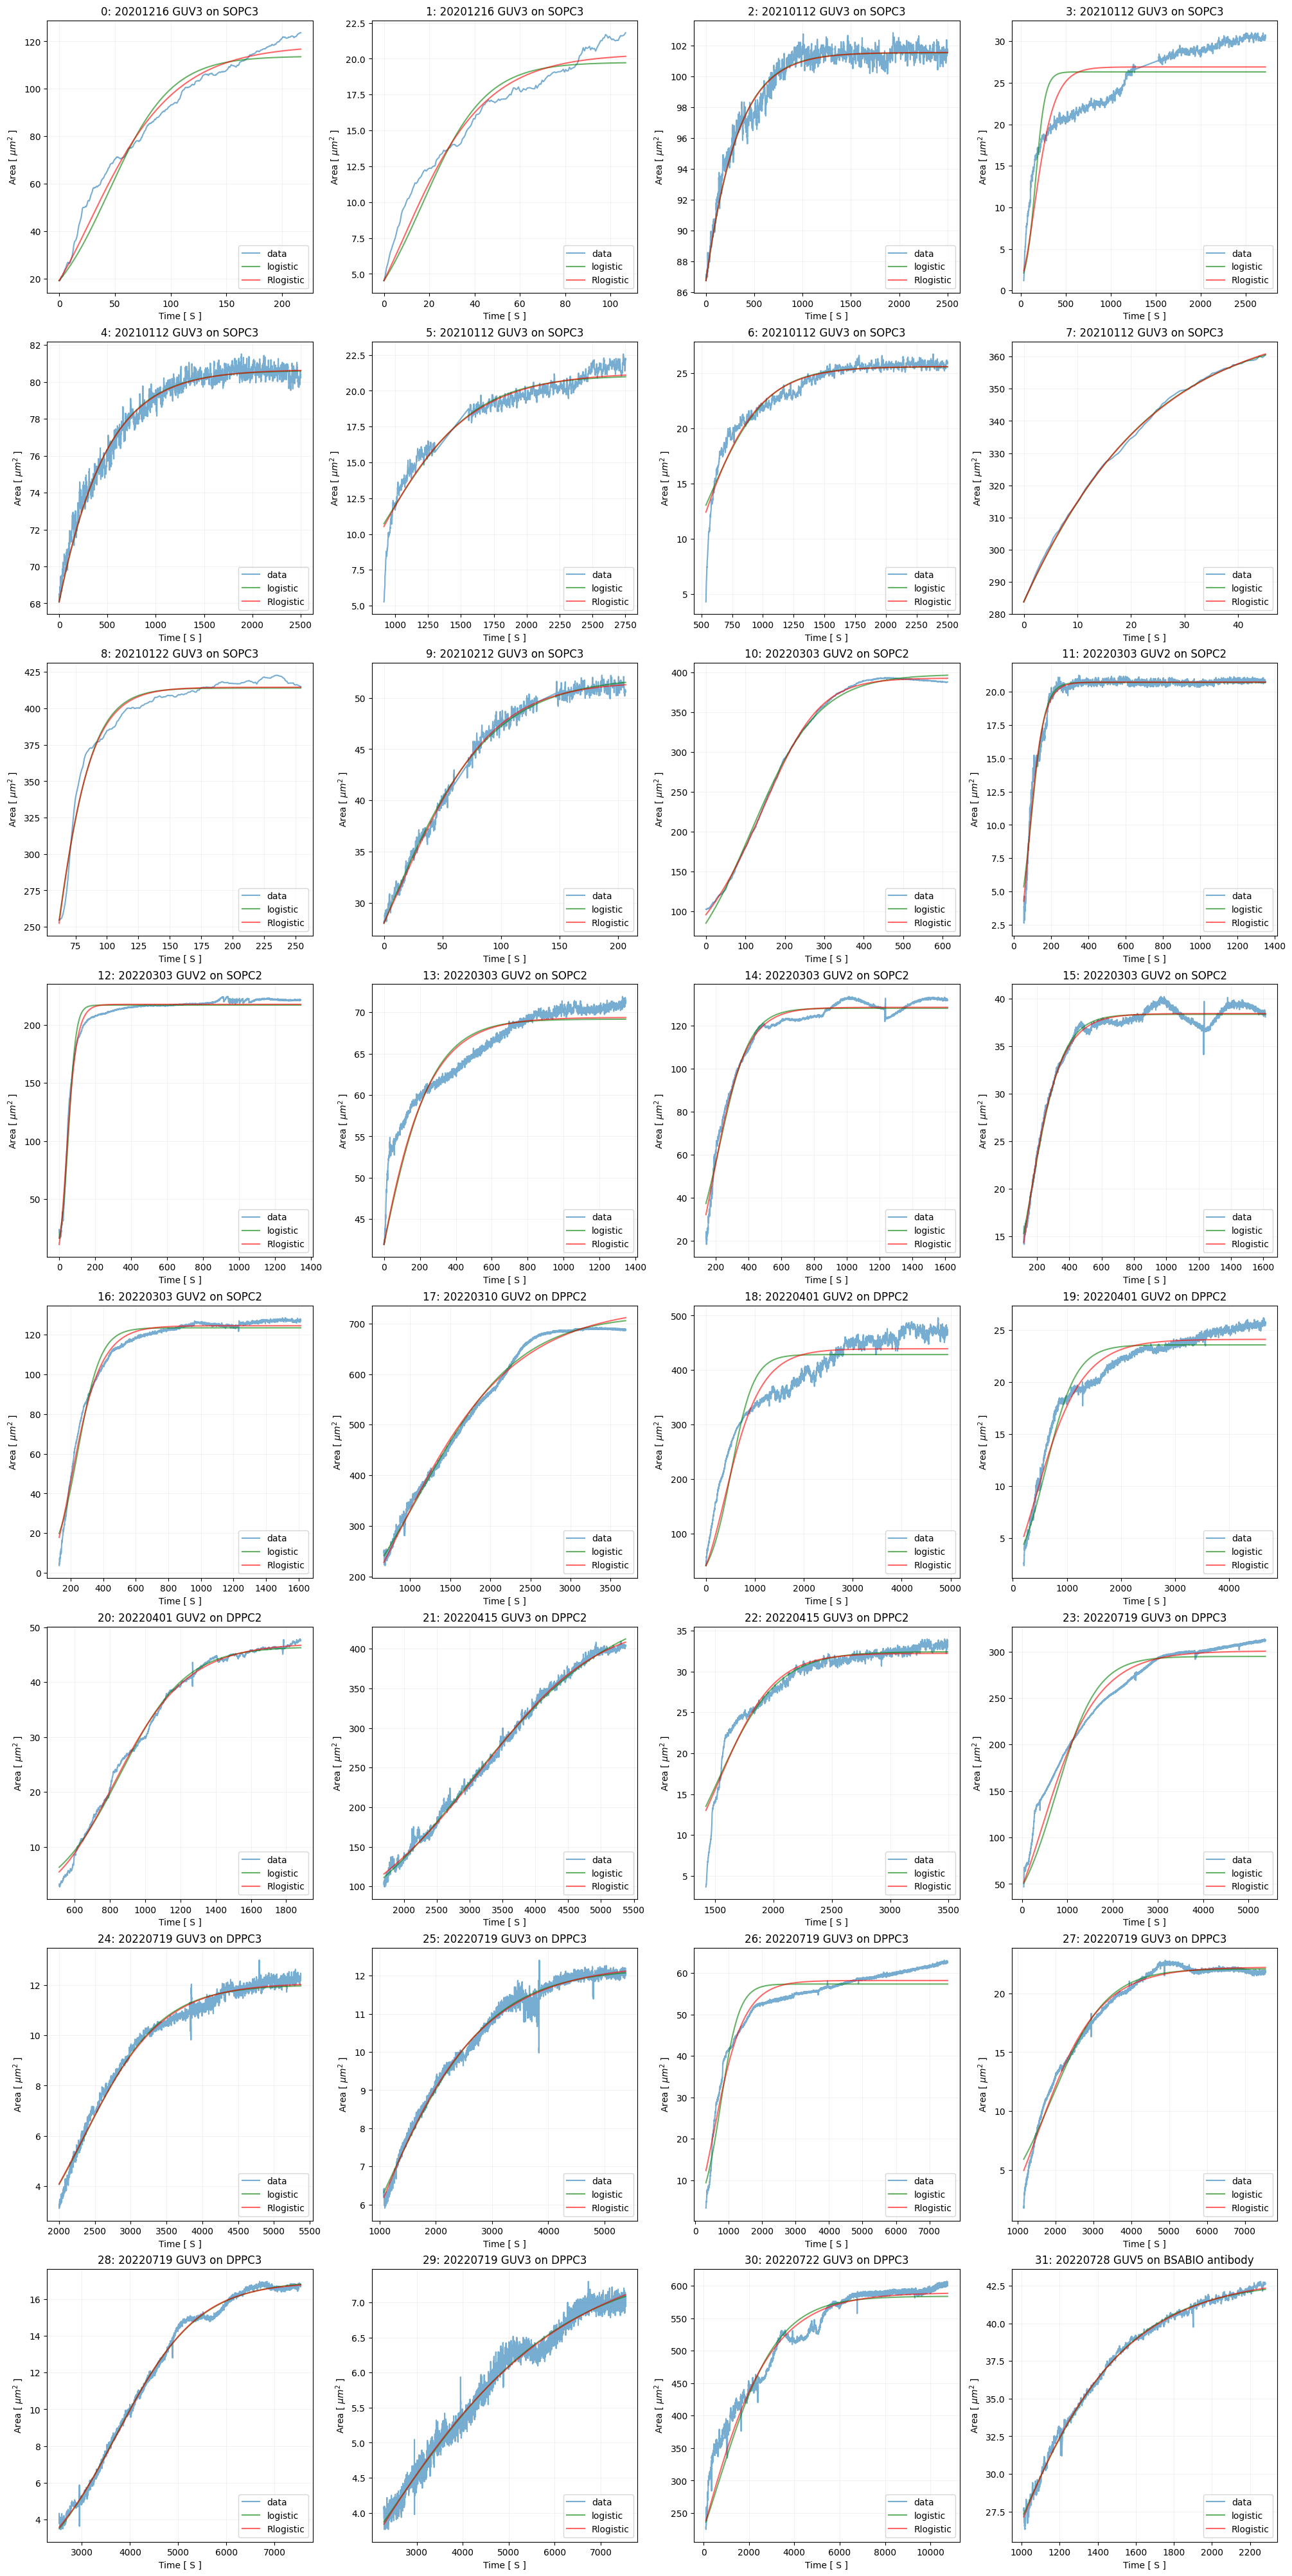

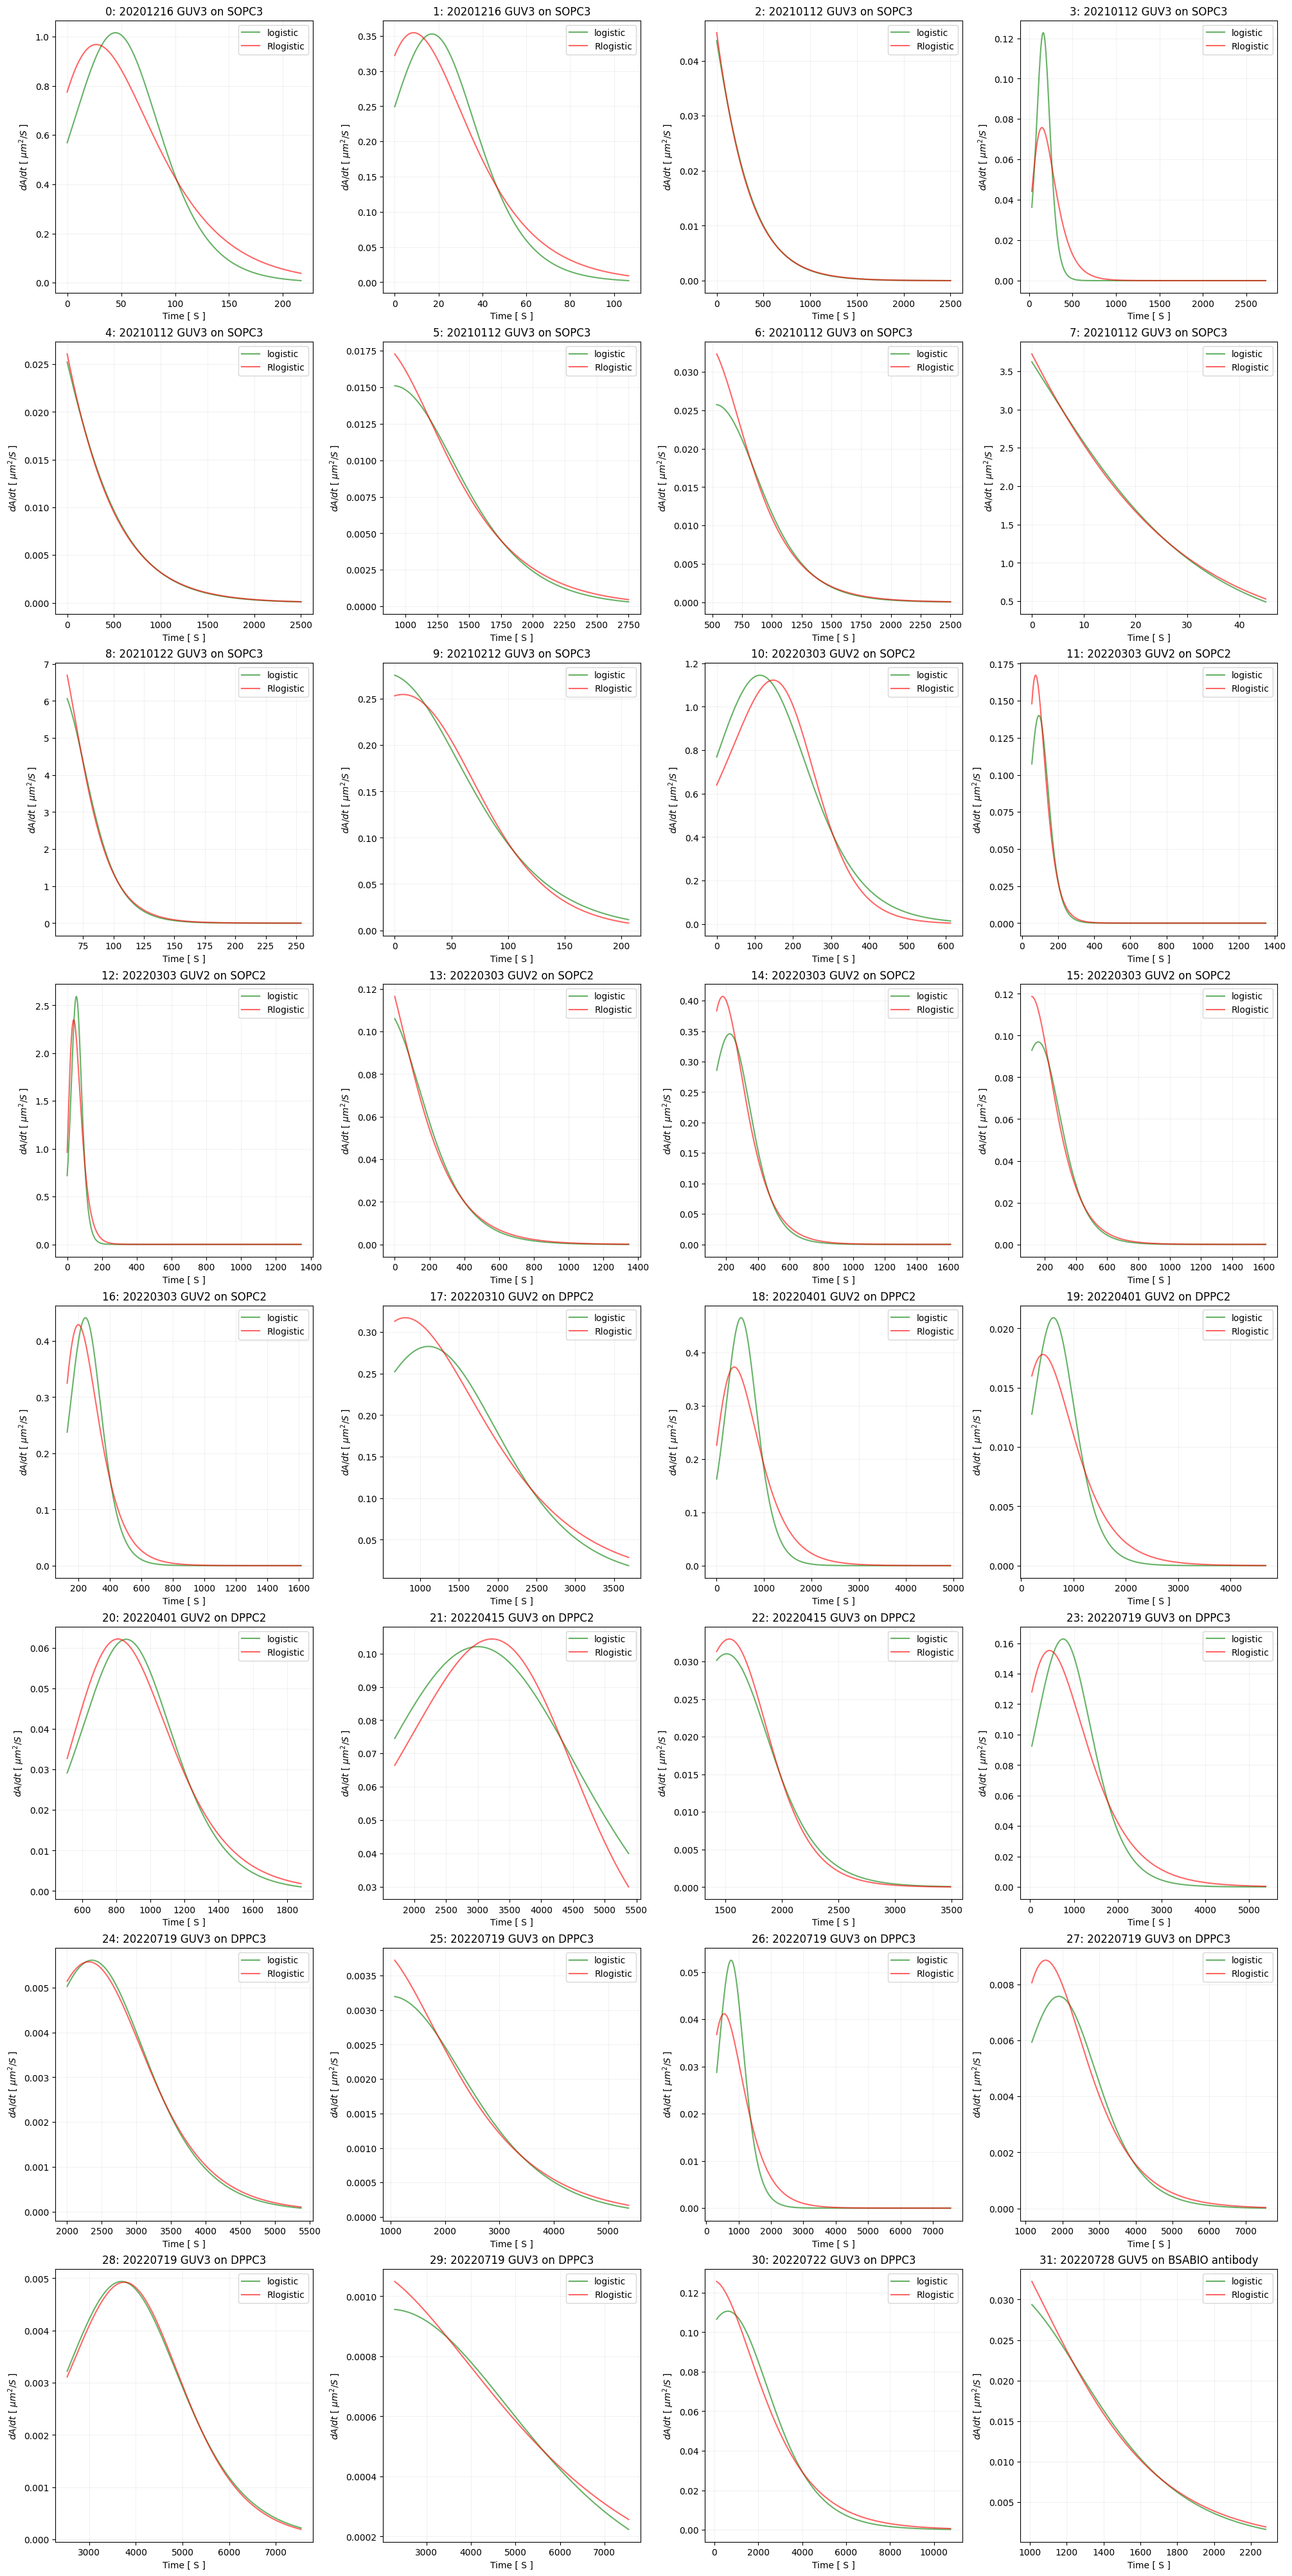

/tmp/ipykernel_14089/947242679.py:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 4, i+1)


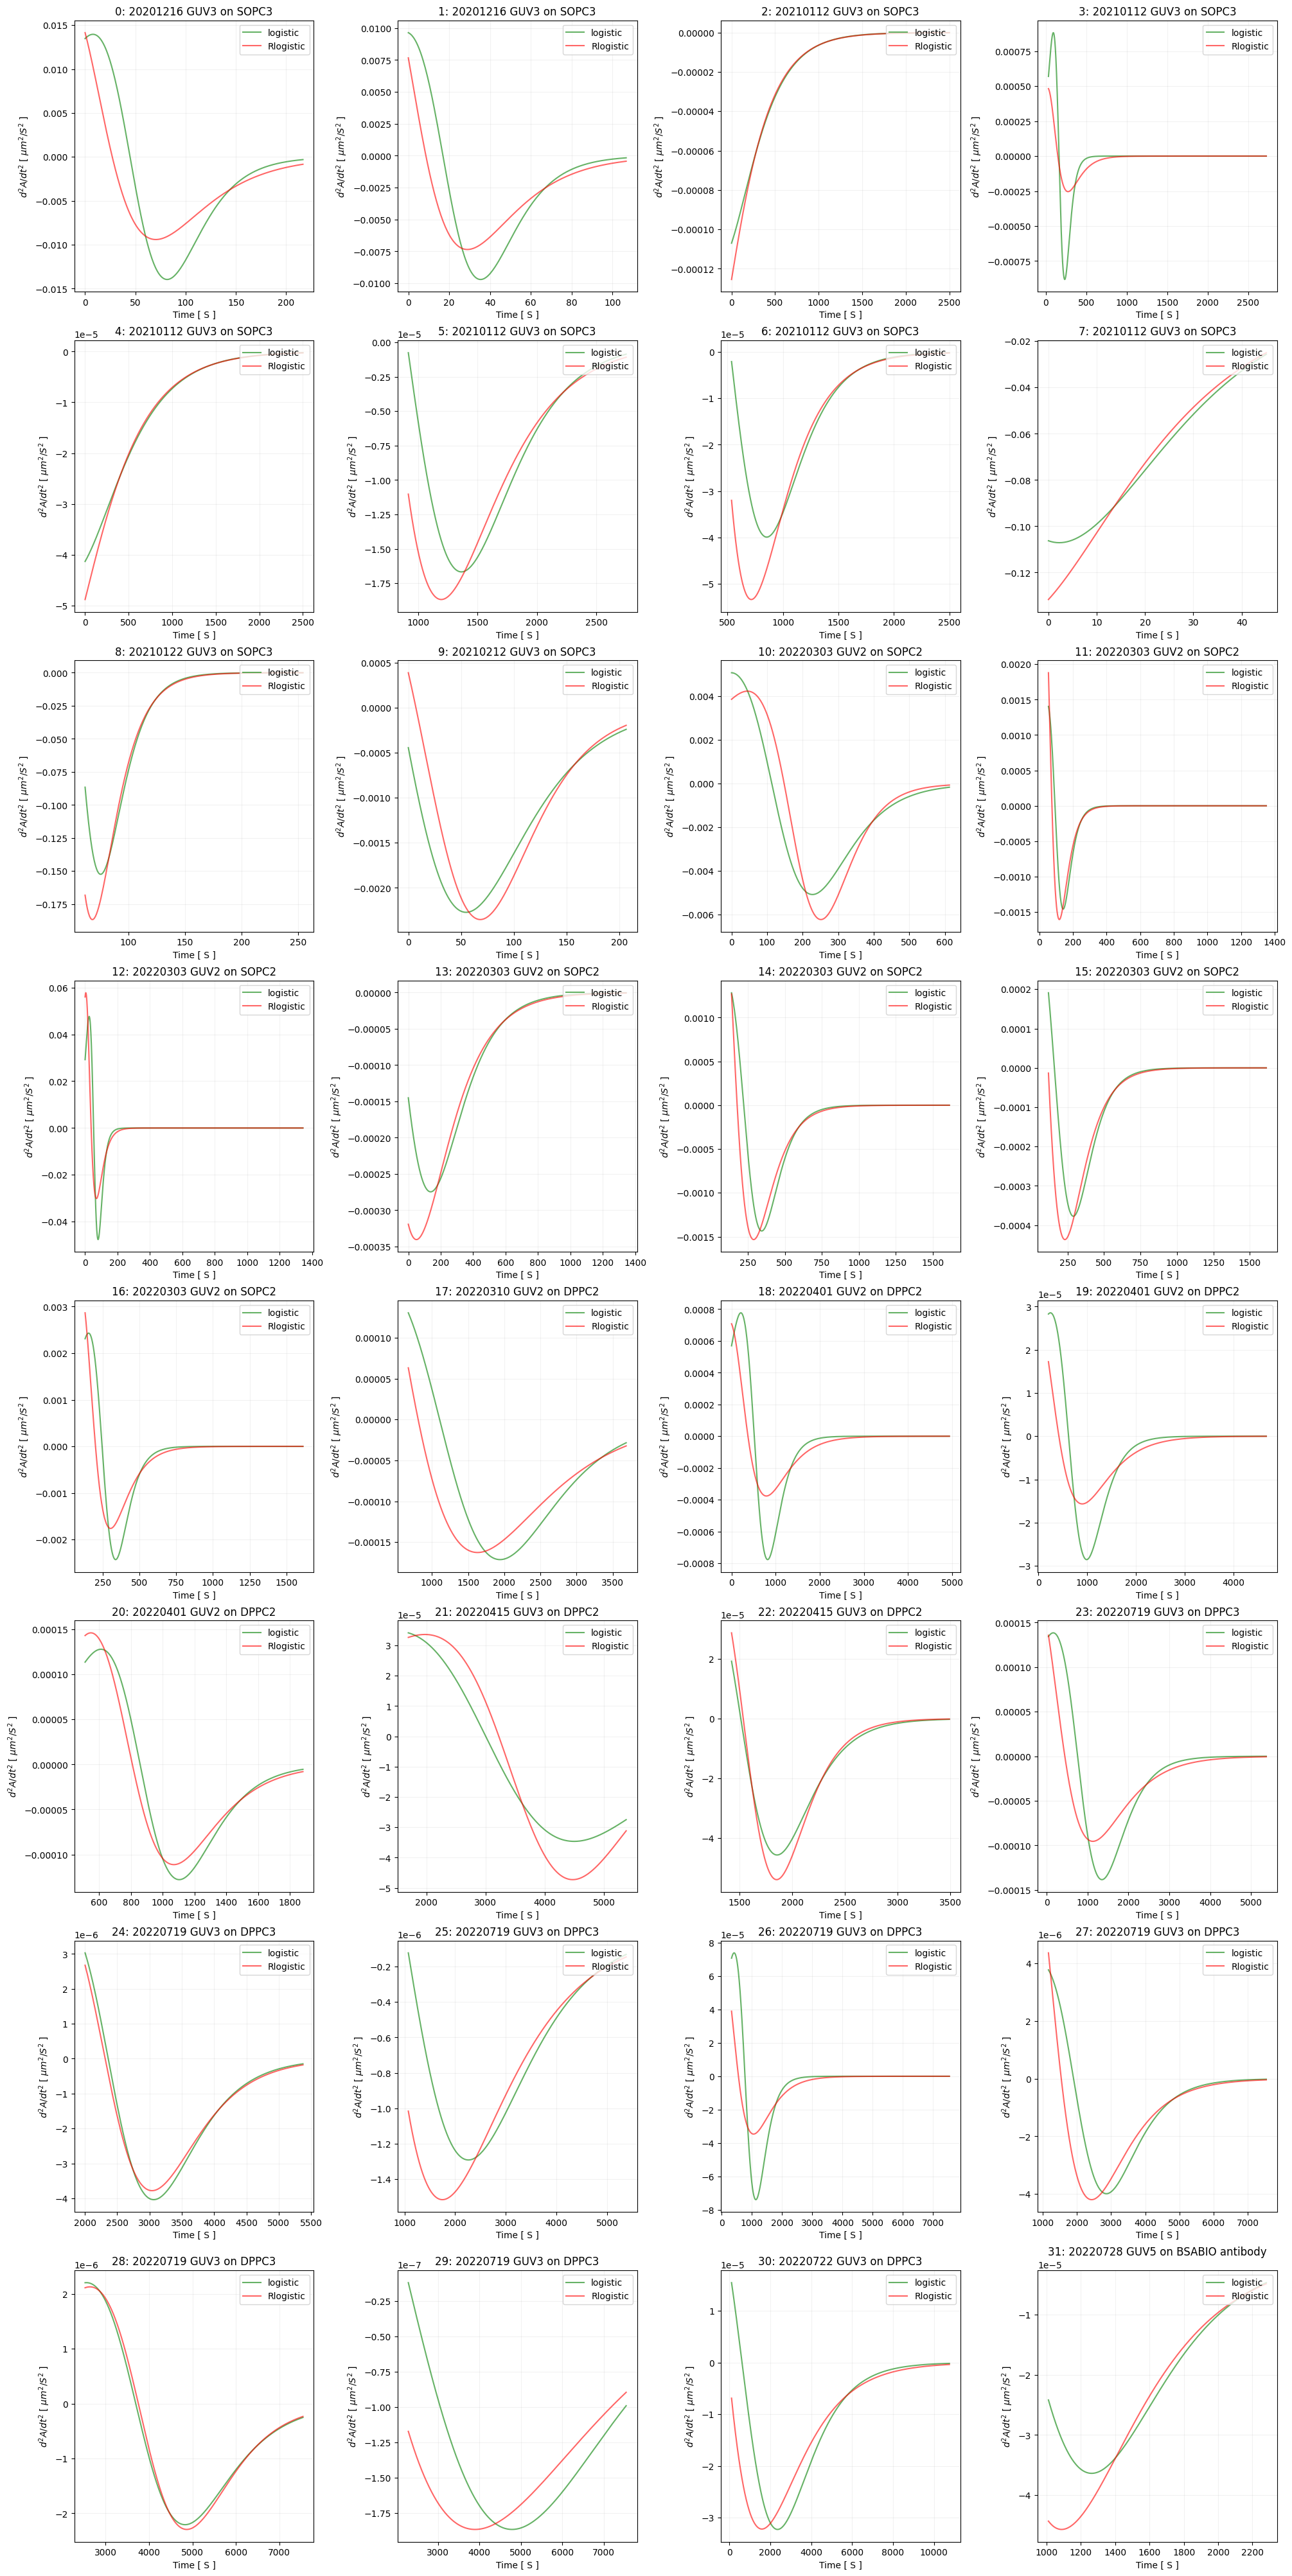

In [3]:
# Read the area curves table
df = pd.read_pickle('Results/manipulated_area_curves.pkl')

parameters_Rlogistic, parameters_logistic = [], []
for i in range(df.shape[0]):
    # Read the time and area
    t, A = df['Time'][i], df['Area'][i]
    
    # Compute the maximum and minimum of the area
    area_max = np.max(A)
    area_min = np.min(A)
    
    # Fit a logistic growth function to the curves  k / (1 + (k/a0 - 1)*np.exp(-r*t)) with parameters a0, r, k
    popt_logistic, _  = curve_fit(area_logistic, t, A,
                                  p0=(1, 0.01, area_max),
                                  bounds=([0.1, 0.00001, area_min], [area_min, 10, 2*area_max]))
    
    # Fit a Richards logistic growth function to the curves  k / (1 + ((k/a0)**u - 1)*np.exp(-r*u*t))**(1/u) with parameters a0, r, k, u
    popt_Rlogistic, _ = curve_fit(area_Rlogistic, t, A, maxfev=5000,
                                  p0=(1, 0.01, area_max, 1),
                                  bounds=([0.1, 0.00001, area_min, 0], [area_min, 10000, 2*area_max, 10]))
    
    # Append the fitted parameters to lists
    parameters_logistic.append(popt_logistic)
    parameters_Rlogistic.append(popt_Rlogistic)
    
    # Define the figure size only once
    if i==0: plt.subplots(8, 4, figsize=(20, 40), constrained_layout=True)
    
    plt.subplot(8, 4, i+1)
    plt.plot(t, A, label='data', alpha = 0.6)                                                    # data
    plt.plot(t, area_logistic(t, *popt_logistic), label='logistic', alpha = 0.6, color= 'g')     # logistic
    plt.plot(t, area_Rlogistic(t, *popt_Rlogistic), label='Rlogistic', alpha = 0.6, color= 'r')  # Rlogistic
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right')
    
plt.savefig('Results/area_curves_2')
plt.show()


# Draw the derivative curves
for i in range(df.shape[0]):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.subplots(8, 4, figsize=(20, 40), constrained_layout=True)
    
    plt.subplot(8, 4, i+1)
    plt.plot(t, der1_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')       # logistic
    plt.plot(t, der1_area_Rlogistic(t, *parameters_Rlogistic[i]), label='Rlogistic', alpha = 0.6, color= 'r')    # Rlogistic
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('$dA/dt$ [ $\mu m^2 / S$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_2_der1')
plt.show()

# Draw the second derivative curves
for i in range(df.shape[0]):
    # Define the time
    t = df['Time'][i]
    
    # Define the figure size only once
    if i==0: plt.subplots(4, 4, figsize=(20, 40), constrained_layout=True)
    
    plt.subplot(8, 4, i+1)
    plt.plot(t, der2_area_logistic(t, *parameters_logistic[i]), label='logistic', alpha = 0.6, color= 'g')       # logistic
    plt.plot(t, der2_area_Rlogistic(t, *parameters_Rlogistic[i]), label='Rlogistic', alpha = 0.6, color= 'r')    # Rlogistic
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('$d^2A/dt^2$ [ $\mu m^2 / S^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Results/area_curves_2_der2')
plt.show()

### Save the parameters to the data frame

In [4]:
# Save the initial data frame with proper name
df.to_pickle('Results/manipulated_area_curves_2.pkl')

# Add columns for the model to the data frame
df['Model_logistic'] = parameters_logistic
df['Model_Rlogistic'] = parameters_Rlogistic

# Save the results data frame as pickle
df.to_pickle('Results/result_area_curves_2.pkl')

# Save a csv and excel to be used out of python
df.drop(['Time', 'Area'], axis=1).to_csv('Results/result_area_curves_2.csv', index=False)
df.drop(['Time', 'Area'], axis=1).to_excel('Results/result_area_curves_2.xlsx', index=False)

df

Date     Protein              Discription  \
0   20201216  Mouse Ecad            GUV3 on SOPC3   
1   20201216  Mouse Ecad            GUV3 on SOPC3   
2   20210112  Mouse Ecad            GUV3 on SOPC3   
3   20210112  Mouse Ecad            GUV3 on SOPC3   
4   20210112  Mouse Ecad            GUV3 on SOPC3   
5   20210112  Mouse Ecad            GUV3 on SOPC3   
6   20210112  Mouse Ecad            GUV3 on SOPC3   
7   20210112  Mouse Ecad            GUV3 on SOPC3   
8   20210122  Mouse Ecad            GUV3 on SOPC3   
9   20210212  Mouse Ecad            GUV3 on SOPC3   
10  20220303  Human Ecad            GUV2 on SOPC2   
11  20220303  Human Ecad            GUV2 on SOPC2   
12  20220303  Human Ecad            GUV2 on SOPC2   
13  20220303  Human Ecad            GUV2 on SOPC2   
14  20220303  Human Ecad            GUV2 on SOPC2   
15  20220303  Human Ecad            GUV2 on SOPC2   
16  20220303  Human Ecad            GUV2 on SOPC2   
17  20220310  Human Ecad            GUV2 on DPPC2   
18  20220401  Human Ecad            GUV2 on DPPC2   
19  20220401  Human Ecad            GUV2 on DPPC2   
20  20220401  Human Ecad            GUV2 on DPPC2   
21  20220415  Human Ecad            GUV3 on DPPC2   
22  20220415  Human Ecad            GUV3 on DPPC2   
23  20220719  Human Ecad            GUV3 on DPPC3   
24  20220719  Human Ecad            GUV3 on DPPC3   
25  20220719  Human Ecad            GUV3 on DPPC3   
26  20220719  Human Ecad            GUV3 on DPPC3   
27  20220719  Human Ecad            GUV3 on DPPC3   
28  20220719  Human Ecad            GUV3 on DPPC3   
29  20220719  Human Ecad            GUV3 on DPPC3   
30  20220722  Human Ecad            GUV3 on DPPC3   
31  20220728  Human Ecad  GUV5 on BSABIO antibody   

                                         Name  \
0                         Calib_camera1and2-1   
1                             Calib_camera3-3   
2   movie-200-550ms-1200-1sec_240_1200-1sec-1   
3   movie-200-550ms-1200-1sec_240_1200-1sec-2   
4   movie-200-550ms-1200-1sec_240_1200-1sec-3   
5   movie-200-550ms-1200-1sec_240_1200-1sec-4   
6   movie-200-550ms-1200-1sec_240_1200-1sec-5   
7                               movie-550ms-1   
8                           movie-1200-3sec-1   
9              movie-600_11_600_16_600-10ms-1   
10       chamber1_vesicle_2_MMStack_Default-1   
11       chamber1_vesicle_2_MMStack_Default-3   
12       chamber2_vesicle_1_MMStack_Default-1   
13       chamber2_vesicle_1_MMStack_Default-2   
14       chamber3_vesicle_1_MMStack_Default-1   
15       chamber3_vesicle_1_MMStack_Default-2   
16       chamber3_vesicle_1_MMStack_Default-3   
17       chamber2_vesicle_2_MMStack_Default-1   
18                     vesicle_1_(809-9999)-1   
19                     vesicle_1_(809-9999)-4   
20                vesicle_2_MMStack_Default-1   
21                vesicle_2_MMStack_Default-2   
22                vesicle_2_MMStack_Default-4   
23            vesicle_1_MMStack_Default.ome-1   
24            vesicle_1_MMStack_Default.ome-3   
25            vesicle_1_MMStack_Default.ome-5   
26                vesicle_7_MMStack_Default-1   
27                vesicle_7_MMStack_Default-4   
28                vesicle_7_MMStack_Default-5   
29                vesicle_7_MMStack_Default-7   
30                vesicle_9_MMStack_Default-1   
31                vesicle_3_MMStack_Default-1   

                                                 Time  \
0   [0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...   
1   [0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...   
2   [0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...   
3   [33.0, 33.55, 34.1, 34.65, 35.2, 35.75, 36.3, ...   
4   [0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...   
5   [916.0, 917.0, 918.0, 919.0, 920.0, 921.0, 922...   
6   [537.0, 538.0, 539.0, 540.0, 541.0, 542.0, 543...   
7   [0.0, 0.55, 1.1, 1.65, 2.2, 2.75, 3.3000000000...   
8   [62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...   
9   [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6000000000000...   
10  [0.0, 0.5

### Print the fitted parameters

In [5]:
from IPython.display import display_html 

parameters_logistic = np.array(parameters_logistic)
parameters_Rlogistic = np.array(parameters_Rlogistic)

df_logistic = pd.DataFrame(data={'A0':parameters_logistic[:,0],
                                 'r':parameters_logistic[:,1],
                                 'k':parameters_logistic[:,2]})

df_Rlogistic = pd.DataFrame(data={'A0':parameters_Rlogistic[:,0],
                                 'r':parameters_Rlogistic[:,1],
                                 'k':parameters_Rlogistic[:,2],
                                 'u':parameters_Rlogistic[:,3]})

df_logistic_style = df_logistic.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("Logistic")
df_Rlogistic_style = df_Rlogistic.style.set_table_attributes("style='display:inline'").set_caption("Richards Logistic")

display_html(df_logistic_style._repr_html_() + df_Rlogistic_style._repr_html_(), raw=True)

Logistic 
 
 
   
 A0 
 r 
 k 
 
 
 
 
 0 
 19.156250 
 0.035715 
 113.749338 
 
 
 1 
 4.531250 
 0.071435 
 19.752447 
 
 
 2 
 86.750000 
 0.003457 
 101.531164 
 
 
 3 
 1.187500 
 0.018662 
 26.303662 
 
 
 4 
 68.078125 
 0.002380 
 80.635397 
 
 
 5 
 1.468136 
 0.002867 
 21.078768 
 
 
 6 
 2.731889 
 0.004028 
 25.569144 
 
 
 7 
 283.781250 
 0.054870 
 369.709273 
 
 
 8 
 13.816401 
 0.061872 
 413.972120 
 
 
 9 
 28.000000 
 0.021295 
 52.064585 
 
 
 10 
 84.906423 
 0.011514 
 397.751899 
 
 
 11 
 1.554885 
 0.027072 
 20.698670 
 
 
 12 
 16.281250 
 0.047772 
 217.061395 
 
 
 13 
 41.953125 
 0.006423 
 69.171543 
 
 
 14 
 10.711694 
 0.010786 
 128.212341 
 
 
 15 
 6.395608 
 0.010111 
 38.359241 
 
 
 16 
 3.609375 
 0.014302 
 123.452387 
 
 
 17 
 106.997216 
 0.001575 
 717.778842 
 
 
 18 
 41.296875 
 0.004341 
 428.466418 
 
 
 19 
 2.375000 
 0.003549 
 23.550561 
 
 
 20 
 0.469333 
 0.005349 
 46.469842 
 
 
 21 
 30.697396 
 0.000881 
 463.311143 
 
 
 22 
 0.100000 
 0.003826 
 32.419482 
 
 
 23 
 46.812500 
 0.002209 
 294.733314 
 
 
 24 
 0.143925 
 0.001870 
 12.006529 
 
 
 25 
 3.150358 
 0.001049 
 12.200519 
 
 
 26 
 3.250000 
 0.003661 
 57.364583 
 
 
 27 
 1.516204 
 0.001371 
 22.086437 
 
 
 28 
 0.229847 
 0.001161 
 17.010139 
 
 
 29 
 1.876657 
 0.000506 
 7.556536 
 
 
 30 
 224.718750 
 0.000758 
 583.984380 
 
 
 31 
 3.443715 
 0.002971 
 42.807619 
 
 
 

 
 Richards Logistic 
 
 
   
 A0 
 r 
 k 
 u 
 
 
 
 
 0 
 19.156250 
 101.392858 
 118.462607 
 0.000219 
 
 
 1 
 4.531250 
 200.025774 
 20.362000 
 0.000237 
 
 
 2 
 86.750000 
 34.844530 
 101.551729 
 0.000095 
 
 
 3 
 1.187500 
 34.799460 
 26.896426 
 0.000220 
 
 
 4 
 68.078124 
 4.219420 
 80.672240 
 0.000535 
 
 
 5 
 0.100000 
 0.036943 
 21.279760 
 0.064582 
 
 
 6 
 0.172621 
 9.429726 
 25.607136 
 0.000382 
 
 
 7 
 283.781246 
 15.772357 
 371.903989 
 0.003077 
 
 
 8 
 0.100000 
 0.390805 
 414.501495 
 0.141750 
 
 
 9 
 28.000000 
 0.012780 
 51.590584 
 2.014781 
 
 
 10 
 95.594917 
 0.006988 
 392.892028 
 2.237901 
 
 
 11 
 0.121569 
 60.210102 
 20.715503 
 0.000365 
 
 
 12 
 11.022852 
 78.354855 
 217.729327 
 0.000374 
 
 
 13 
 41.953125 
 14.474991 
 69.381959 
 0.000381 
 
 
 14 
 1.279675 
 23.255443 
 128.614522 
 0.000370 
 
 
 15 
 2.677816 
 9.622549 
 38.433373 
 0.000873 
 
 
 16 
 0.186325 
 31.245131 
 124.496649 
 0.000300 
 
 
 17 
 55.972188 
 5.095587 
 736.330308 
 0.000230 
 
 
 18 
 41.296874 
 9.915092 
 439.082684 
 0.000233 
 
 
 19 
 2.375000 
 7.466766 
 24.085782 
 0.000269 
 
 
 20 
 0.100000 
 0.009539 
 47.143303 
 0.459769 
 
 
 21 
 42.045005 
 0.000614 
 434.337342 
 2.060564 
 
 
 22 
 0.100000 
 0.003676 
 32.220303 
 1.172328 
 
 
 23 
 46.812332 
 6.613369 
 300.621664 
 0.000212 
 
 
 24 
 0.100000 
 0.002192 
 12.077766 
 0.787008 
 
 
 25 
 2.117993 
 1.957926 
 12.315528 
 0.000446 
 
 
 26 
 3.250000 
 6.457545 
 58.213387 
 0.000298 
 
 
 27 
 0.109431 
 4.213402 
 22.231358 
 0.000257 
 
 
 28 
 0.298389 
 0.001035 
 16.936157 
 1.187751 
 
 
 29 
 1.410337 
 1.186800 
 7.808161 
 0.000324 
 
 
 30 
 224.718750 
 4.087450 
 589.501732 
 0.000142 
 
 
 31 
 0.100004 
 0.246017 
 43.095107 
 0.010465

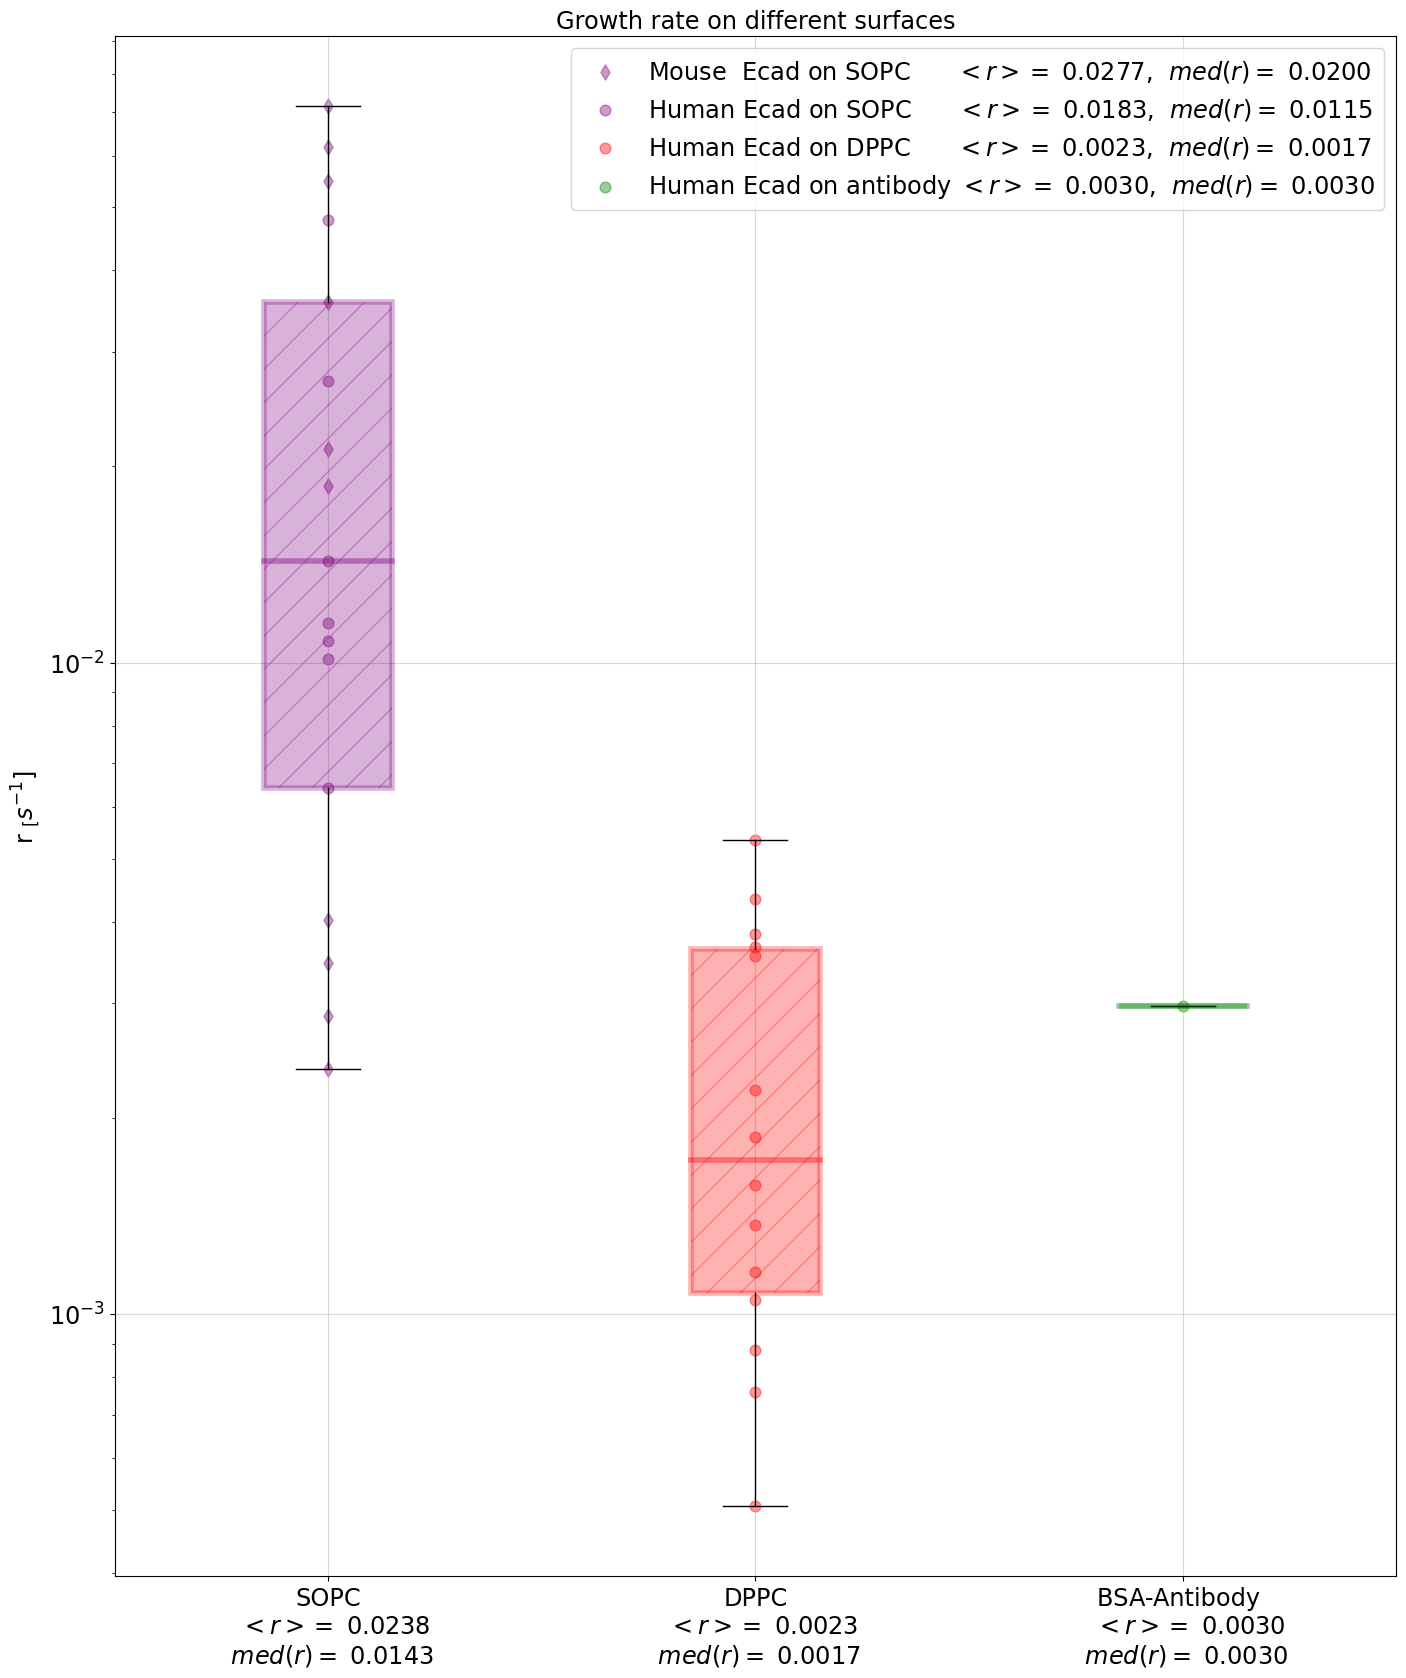

In [6]:
# Extract the logistic parameters excluding the DPPC curve
r = np.array([parameter[1] for parameter in df['Model_logistic']])
k = np.array([parameter[2] for parameter in df['Model_logistic']])
a = np.array([parameter[0] for parameter in df['Model_logistic']])

plt.figure(figsize=(16.54,20))     # 16.54,20

# Define the boxes
bp = plt.boxplot([r[:17], r[17:-1], r[-1]],
                labels = [f'SOPC\n  $<r>=$ {r[:17].mean():.4f}\n $med(r)=$ {np.median(r[:17]):.4f}',
                          f'DPPC\n  $<r>=$ {r[17:-1].mean():.4f}\n $med(r)=$ {np.median(r[17:-1]):.4f}',
                          f'BSA-Antibody \n  $<r>=$ {r[-1:].mean():.4f}\n $med(r)=$ {np.median(r[-1:]):.4f}'],
                patch_artist=True);

# Customize the boxes
bp['boxes'][0].set(color = 'purple', hatch = '/', linewidth=4, alpha = 0.3)
bp['boxes'][1].set(color = 'red', hatch = '/', linewidth=4, alpha = 0.3)
bp['boxes'][2].set(color = 'green', hatch = '/', linewidth=4, alpha = 0.3)

# Customize the Median line
bp['medians'][0].set(color = 'purple', linewidth=4, alpha = 0.4)
bp['medians'][1].set(color = 'red', linewidth=4, alpha = 0.4)
bp['medians'][2].set(color = 'green', linewidth=4, alpha = 0.4)


# Plot the scattered points
plt.scatter(x = [1] * len(r[:10]), y = r[:10], color='purple', marker='d', s = 60, alpha = 0.4,
            label= f'Mouse  Ecad on SOPC      $<r>=$ {r[:10].mean():.4f},  $med(r)=$ {np.median(r[:10]):.4f}')
plt.scatter(x = [1] * len(r[10:17]), y = r[10:17], color='purple', s = 60, alpha = 0.4,
            label= f'Human Ecad on SOPC      $<r>=$ {r[10:17].mean():.4f},  $med(r)=$ {np.median(r[10:17]):.4f}')
plt.scatter(x = [2] * len(r[17:-1]), y = r[17:-1], color='red', s = 60, alpha = 0.4,
            label= f'Human Ecad on DPPC      $<r>=$ {r[17:-1].mean():.4f},  $med(r)=$ {np.median(r[17:-1]):.4f}')
plt.scatter(x = [3], y = r[-1], color='green', s = 60, alpha = 0.4,
            label= f'Human Ecad on antibody $<r>=$ {r[-1].mean():.4f},  $med(r)=$ {np.median(r[-1]):.4f}')

# Customize the table
plt.ylabel('r $_[s^{-1}$]', fontsize= 'xx-large')
plt.xticks(fontsize= 'xx-large')
plt.yticks(fontsize= 'xx-large')
plt.yscale('log')
plt.title('Growth rate on different surfaces', fontsize='xx-large')
plt.grid(alpha=0.5)
plt.legend(fontsize='xx-large')

# Save the figure
plt.savefig("Results/boxplot_growth_rate")
plt.show()

### Plot the growth rate vs carrying capacity

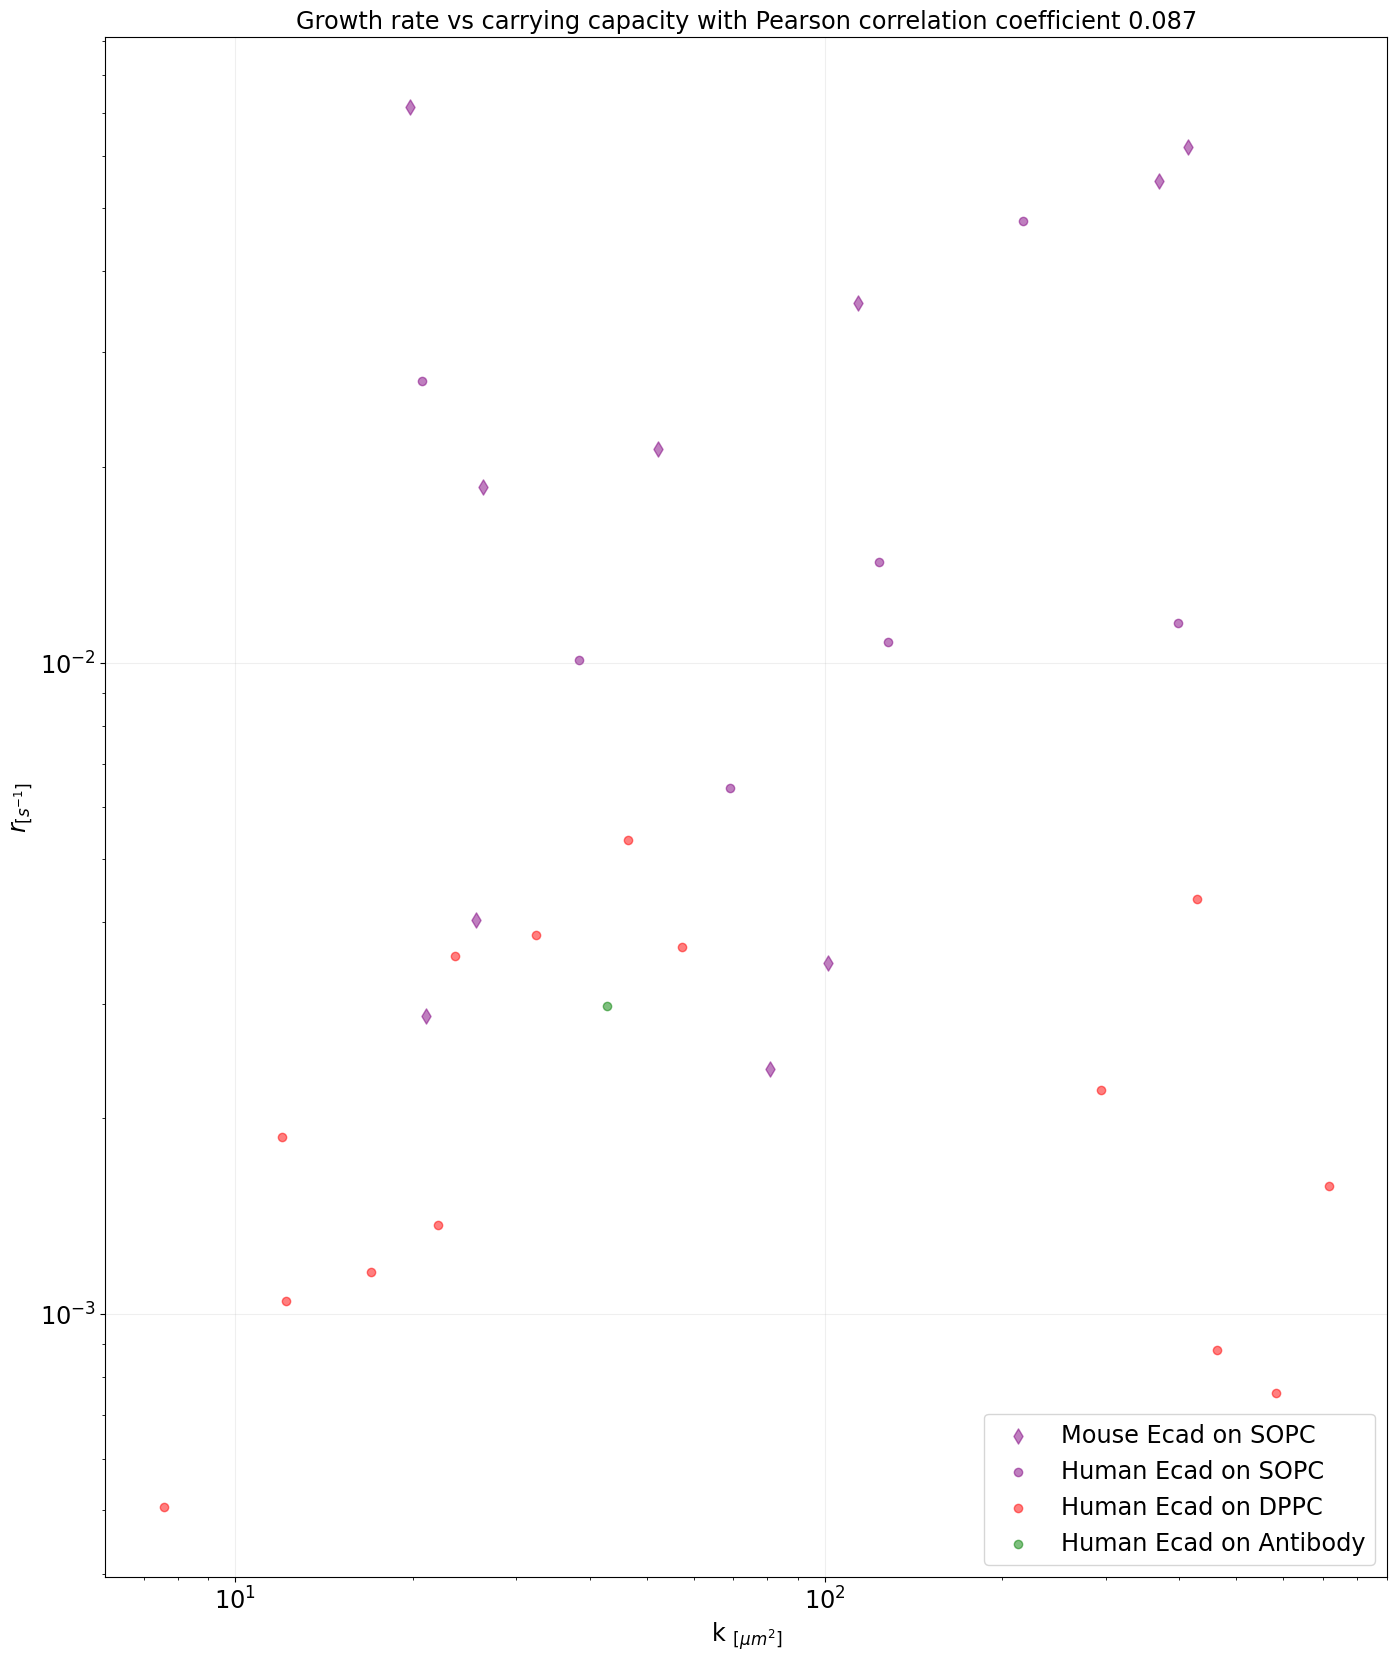

In [7]:
# Calculate the slope and intercept of the growth rate and carrying capacity
m, b = np.polyfit(k, r, 1)

# Calculate the Pearson correlation coefficient
p = np.corrcoef(k, r)[0][1]

# Plot the results
plt.figure(figsize=(16.54,20))

# Scatter the growth rate against the carrying capacity
plt.scatter(k[:10], r[:10], color='purple', alpha = 0.5, label='Mouse Ecad on SOPC', marker='d', s = 60)
plt.scatter(k[10:17], r[10:17], color='purple', alpha = 0.5, label='Human Ecad on SOPC')
plt.scatter(k[17:-1], r[17:-1], color='red', alpha = 0.5, label='Human Ecad on DPPC')
plt.scatter(k[-1:], r[-1:], color='green', alpha = 0.5, label='Human Ecad on Antibody')


# # Annotate each data point with it's index and initial area
# for i, A in enumerate(a): plt.annotate(f'[{i}]  {A:.1f}', (r[i], k[i]), fontsize='large')

# # plot the fitted line between the data points
# m, b = np.polyfit(k[:17], r[:17], 1)
# plt.plot(np.sort(k[:17]), m*np.sort(k[:17]) + b, color='purple', alpha = 0.3, label=f'SOPC  {np.corrcoef(k[:17], r[:17])[0][1]:.3f}')

# m, b = np.polyfit(k[17:-1], r[17:-1], 1)
# plt.plot(np.sort(k[17:-1]), m*np.sort(k[17:-1]) + b, color='red', alpha = 0.3, label=f'DPPC  {np.corrcoef(k[17:-1], r[17:-1])[0][1]:.3f}')

# m, b = np.polyfit(k, r, 1)
# plt.plot(np.sort(k), m*np.sort(k) + b, color='black', alpha = 0.3, label=f'ALL     {np.corrcoef(k, r)[0][1]:.3f}')

plt.xlabel('k $_{[\mu m^2]}$', fontsize='xx-large')
plt.ylabel('$r_{[s^{-1}]}$', fontsize='xx-large')
plt.title(f'Growth rate vs carrying capacity with Pearson correlation coefficient {p:.3f}', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha = 0.2)
plt.legend(fontsize='xx-large')

plt.savefig('Results/Growth_rate_vs_carrying_capacity')

### Plot a histogram for the growth rate and the carrying capacity

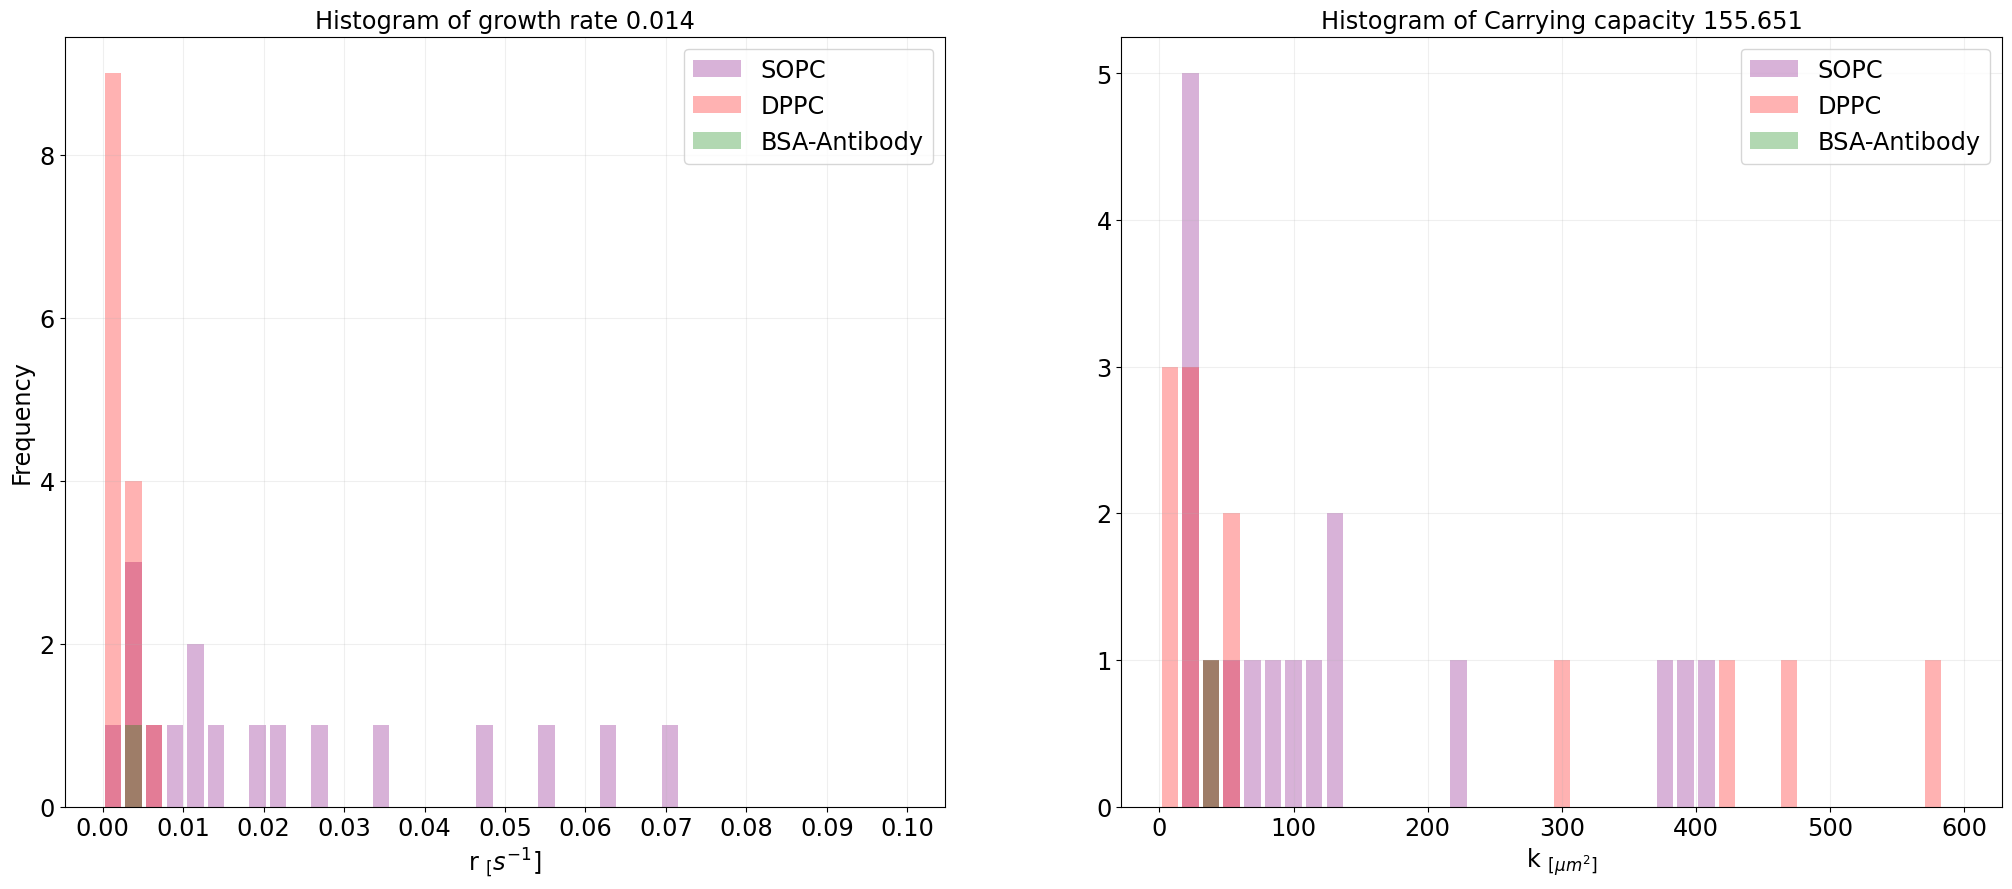

In [8]:
# Plot the results
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.hist(r[:17], bins=np.linspace(0,0.1,40), alpha=0.3, color = 'purple', label='SOPC', rwidth=0.8)
plt.hist(r[17:-1], bins=np.linspace(0,0.1,40), alpha=0.3, color = 'red', label='DPPC', rwidth=0.8)
plt.hist(r[-1:], bins=np.linspace(0,0.1,40), alpha=0.3, color = 'green', label='BSA-Antibody', rwidth=0.8)
plt.xlabel('r $_[s^{-1}]$', fontsize='xx-large')
plt.ylabel('Frequency', fontsize='xx-large')
plt.title(f'Histogram of growth rate {r.mean():.3f}', fontsize='xx-large')
plt.xticks(np.arange(0,0.11,0.01), fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)
plt.legend(fontsize='xx-large')

plt.subplot(1,2,2)
plt.hist(k[:17], bins=np.linspace(0,600,40), alpha=0.3, color = 'purple', label='SOPC', rwidth=0.8)
plt.hist(k[17:-1], bins=np.linspace(0,600,40), alpha=0.3, color = 'red', label='DPPC', rwidth=0.8)
plt.hist(k[-1:], bins=np.linspace(0,600,40), alpha=0.3, color = 'green', label='BSA-Antibody', rwidth=0.8)
plt.xlabel('k $_{[\mu m^2]}$', fontsize='xx-large')
#plt.ylabel('Frequency', fontsize='xx-large')
plt.title(f'Histogram of Carrying capacity {k.mean():.3f}', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.grid(alpha = 0.2)
plt.legend(fontsize='xx-large')

plt.savefig('Results/Growth_rate_and_carrying_capacity histograms')

In [9]:
# Extract the logistic parameters excluding the DPPC curve
r = np.array([parameter[1] for parameter in df['Model_Rlogistic']])
k = np.array([parameter[2] for parameter in df['Model_Rlogistic']])
a = np.array([parameter[0] for parameter in df['Model_Rlogistic']])
u = np.array([parameter[3] for parameter in df['Model_Rlogistic']])

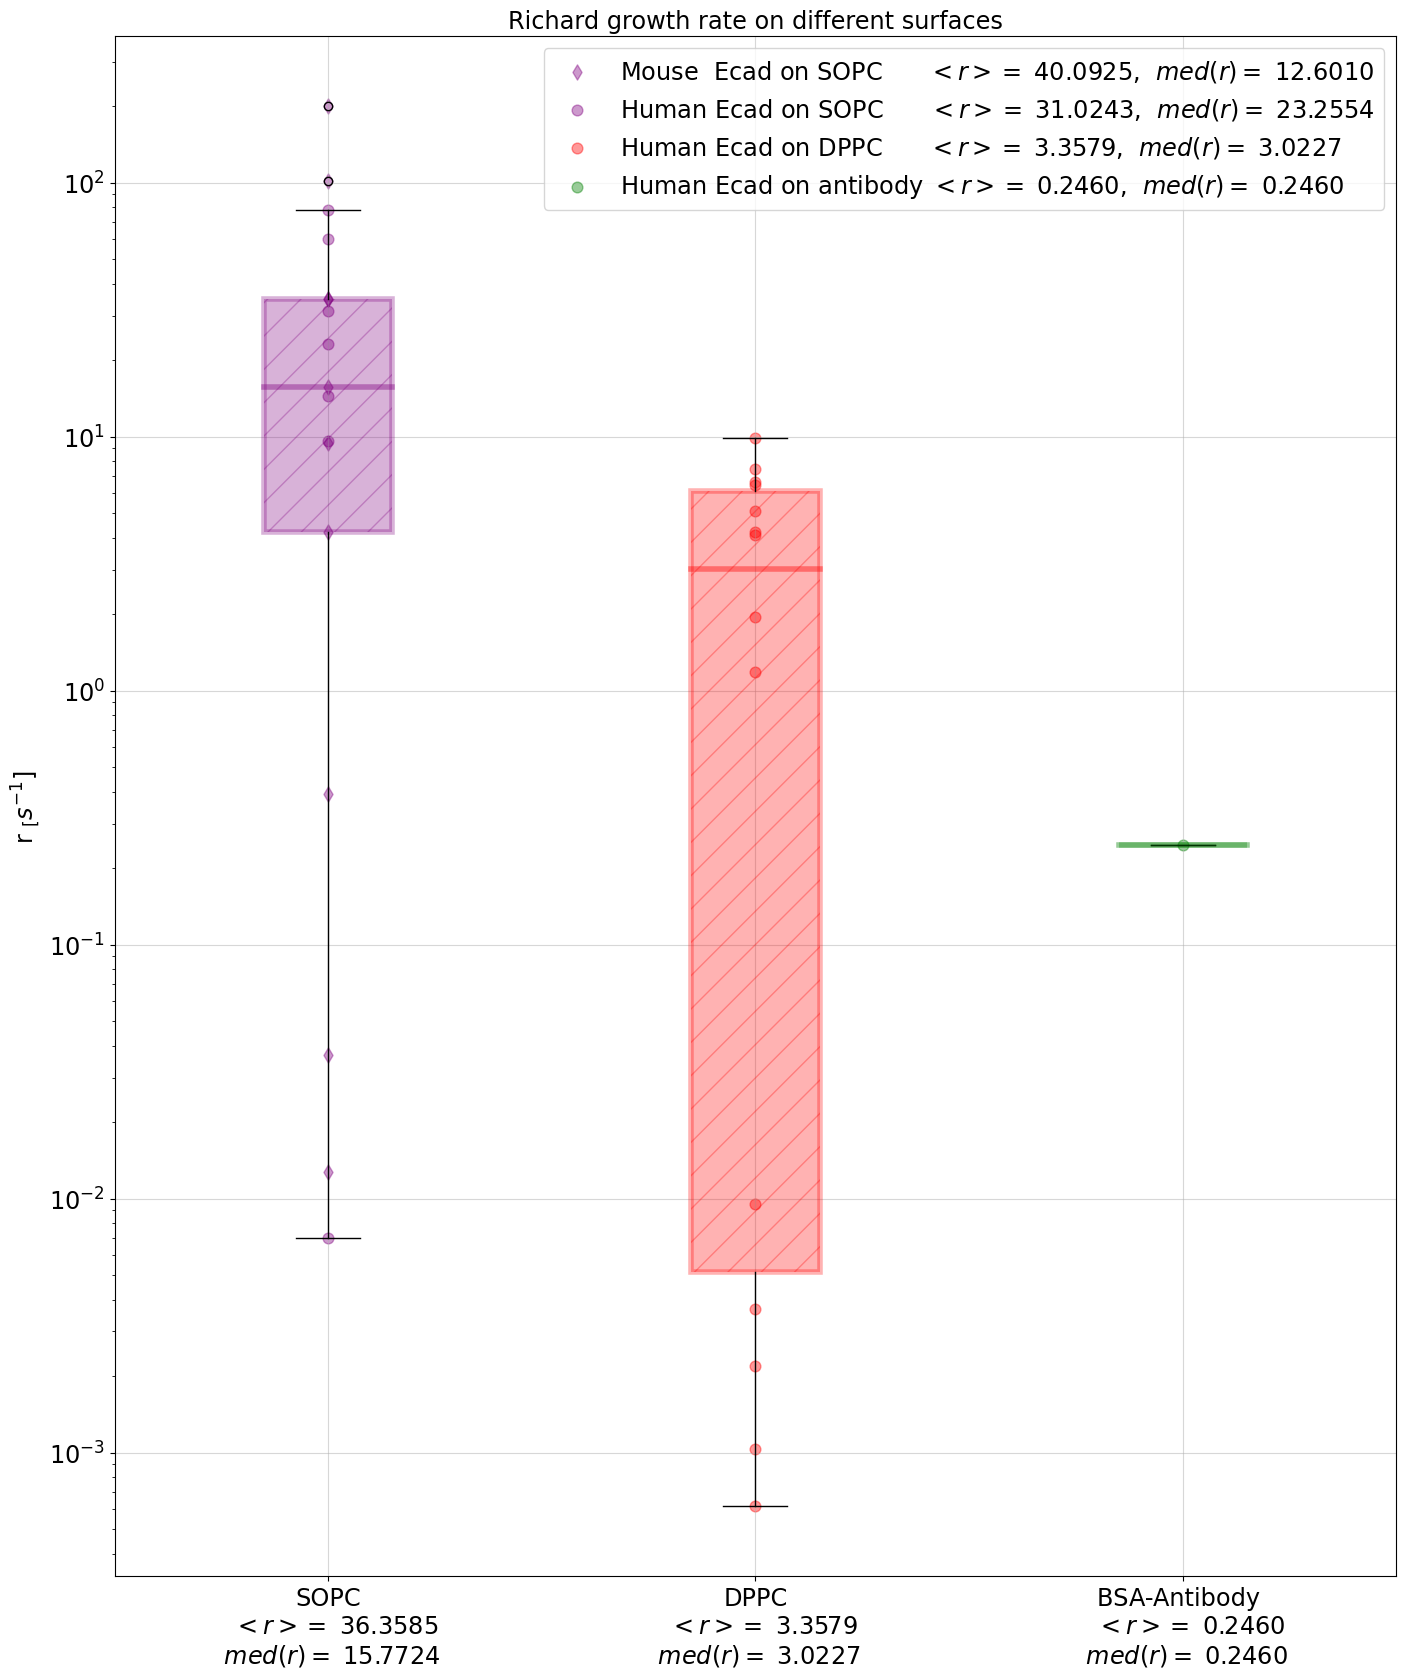

In [10]:
plt.figure(figsize=(16.54,20))     # 16.54,20

# Define the boxes
bp = plt.boxplot([r[:17], r[17:-1], r[-1]],
                labels = [f'SOPC\n  $<r>=$ {r[:17].mean():.4f}\n $med(r)=$ {np.median(r[:17]):.4f}',
                          f'DPPC\n  $<r>=$ {r[17:-1].mean():.4f}\n $med(r)=$ {np.median(r[17:-1]):.4f}',
                          f'BSA-Antibody \n  $<r>=$ {r[-1:].mean():.4f}\n $med(r)=$ {np.median(r[-1:]):.4f}'],
                patch_artist=True);

# Customize the boxes
bp['boxes'][0].set(color = 'purple', hatch = '/', linewidth=4, alpha = 0.3)
bp['boxes'][1].set(color = 'red', hatch = '/', linewidth=4, alpha = 0.3)
bp['boxes'][2].set(color = 'green', hatch = '/', linewidth=4, alpha = 0.3)

# Customize the Median line
bp['medians'][0].set(color = 'purple', linewidth=4, alpha = 0.4)
bp['medians'][1].set(color = 'red', linewidth=4, alpha = 0.4)
bp['medians'][2].set(color = 'green', linewidth=4, alpha = 0.4)


# Plot the scattered points
plt.scatter(x = [1] * len(r[:10]), y = r[:10], color='purple', marker='d', s = 60, alpha = 0.4,
            label= f'Mouse  Ecad on SOPC      $<r>=$ {r[:10].mean():.4f},  $med(r)=$ {np.median(r[:10]):.4f}')
plt.scatter(x = [1] * len(r[10:17]), y = r[10:17], color='purple', s = 60, alpha = 0.4,
            label= f'Human Ecad on SOPC      $<r>=$ {r[10:17].mean():.4f},  $med(r)=$ {np.median(r[10:17]):.4f}')
plt.scatter(x = [2] * len(r[17:-1]), y = r[17:-1], color='red', s = 60, alpha = 0.4,
            label= f'Human Ecad on DPPC      $<r>=$ {r[17:-1].mean():.4f},  $med(r)=$ {np.median(r[17:-1]):.4f}')
plt.scatter(x = [3], y = r[-1], color='green', s = 60, alpha = 0.4,
            label= f'Human Ecad on antibody $<r>=$ {r[-1].mean():.4f},  $med(r)=$ {np.median(r[-1]):.4f}')

# Customize the table
plt.ylabel('r $_[s^{-1}$]', fontsize= 'xx-large')
plt.xticks(fontsize= 'xx-large')
plt.yticks(fontsize= 'xx-large')
plt.yscale('log')
plt.title('Richard growth rate on different surfaces', fontsize='xx-large')
plt.grid(alpha=0.5)
plt.legend(fontsize='xx-large')

# Save the figure
plt.savefig("Results/boxplot_Richard_growth_rate")
plt.show()

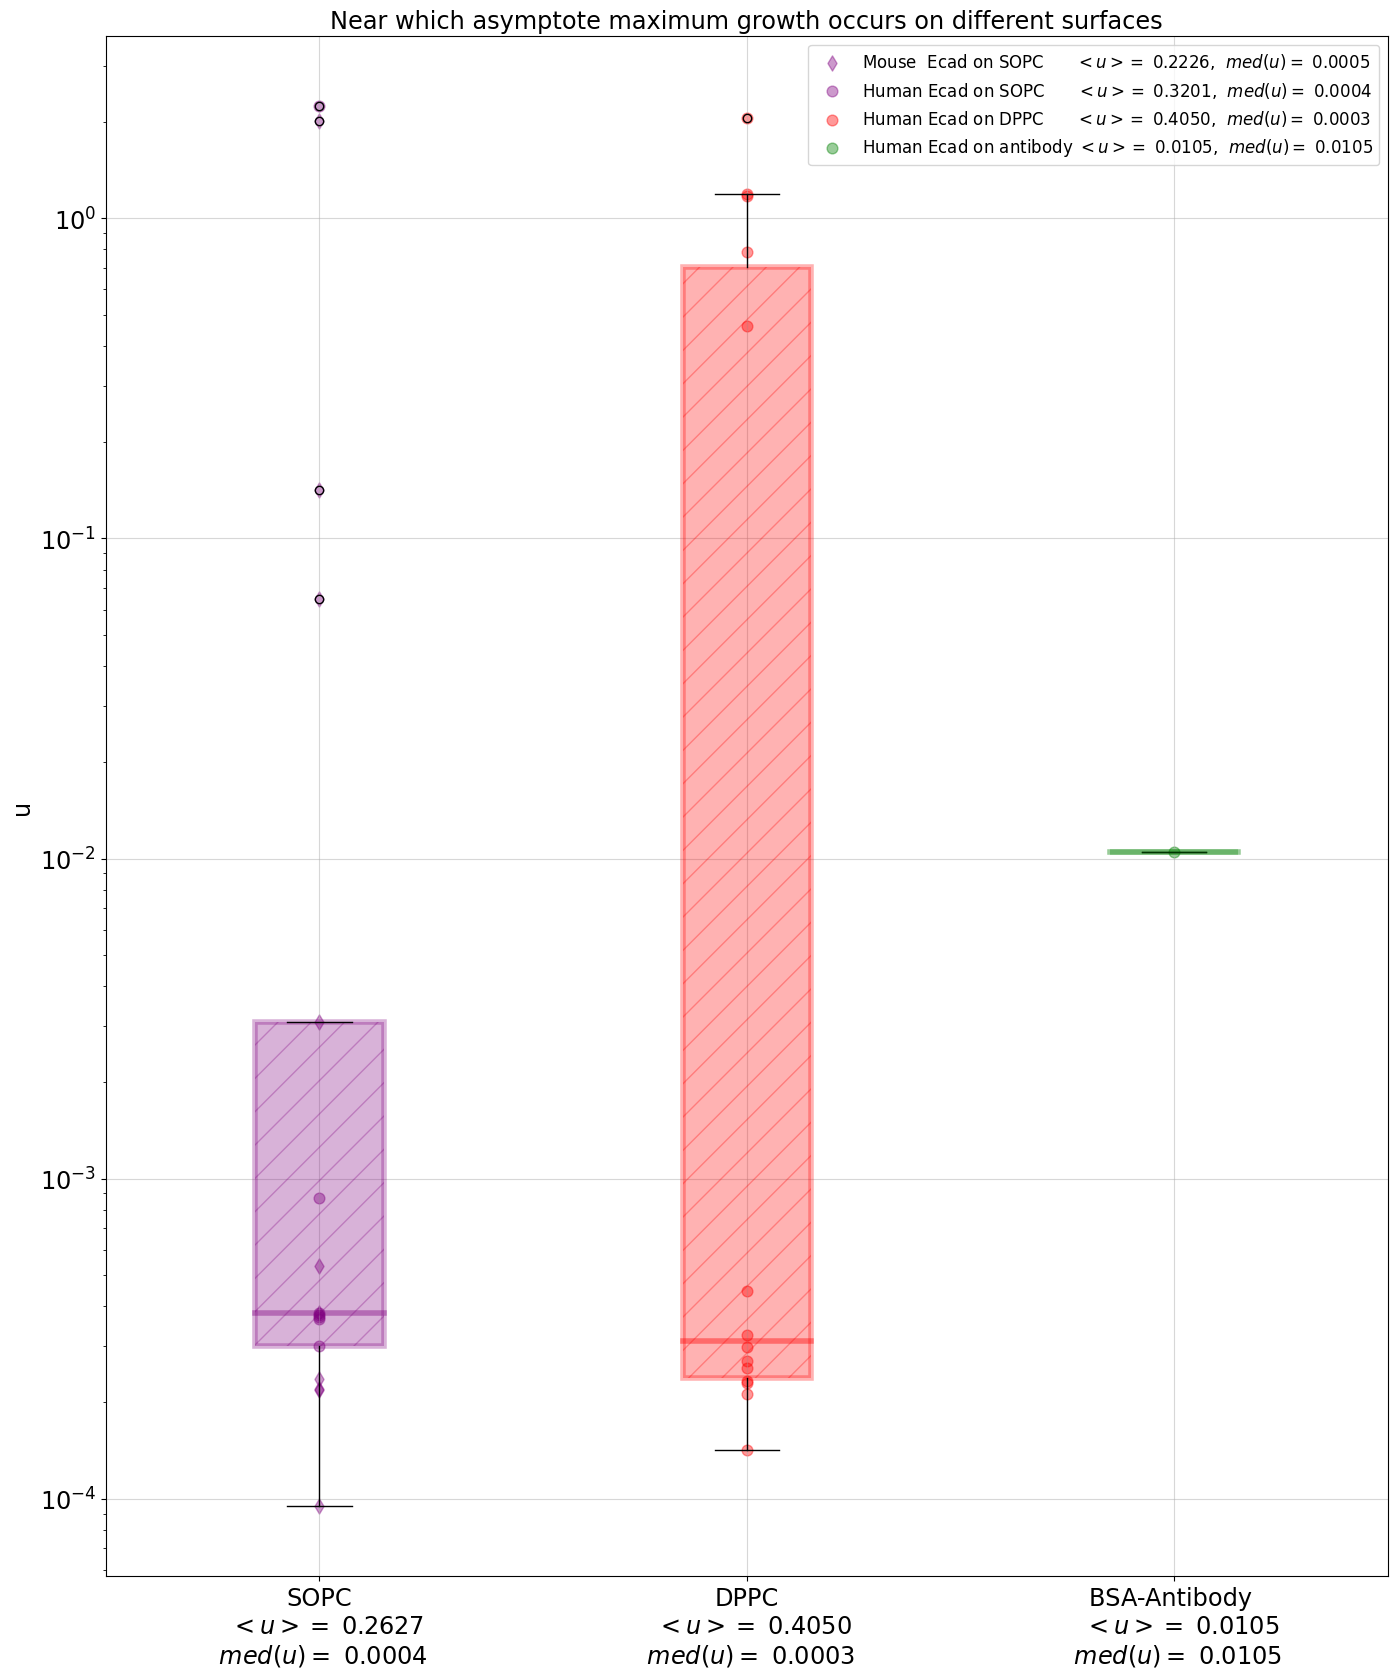

In [11]:
plt.figure(figsize=(16.54,20))     # 16.54,20

# Define the boxes
bp = plt.boxplot([u[:17], u[17:-1], u[-1]],
                labels = [f'SOPC\n  $<u>=$ {u[:17].mean():.4f}\n $med(u)=$ {np.median(u[:17]):.4f}',
                          f'DPPC\n  $<u>=$ {u[17:-1].mean():.4f}\n $med(u)=$ {np.median(u[17:-1]):.4f}',
                          f'BSA-Antibody \n  $<u>=$ {u[-1:].mean():.4f}\n $med(u)=$ {np.median(u[-1:]):.4f}'],
                patch_artist=True);

# Customize the boxes
bp['boxes'][0].set(color = 'purple', hatch = '/', linewidth=4, alpha = 0.3)
bp['boxes'][1].set(color = 'red', hatch = '/', linewidth=4, alpha = 0.3)
bp['boxes'][2].set(color = 'green', hatch = '/', linewidth=4, alpha = 0.3)

# Customize the Median line
bp['medians'][0].set(color = 'purple', linewidth=4, alpha = 0.4)
bp['medians'][1].set(color = 'red', linewidth=4, alpha = 0.4)
bp['medians'][2].set(color = 'green', linewidth=4, alpha = 0.4)


# Plot the scattered points
plt.scatter(x = [1] * len(u[:10]), y = u[:10], color='purple', marker='d', s = 60, alpha = 0.4,
            label= f'Mouse  Ecad on SOPC      $<u>=$ {u[:10].mean():.4f},  $med(u)=$ {np.median(u[:10]):.4f}')
plt.scatter(x = [1] * len(u[10:17]), y = u[10:17], color='purple', s = 60, alpha = 0.4,
            label= f'Human Ecad on SOPC      $<u>=$ {u[10:17].mean():.4f},  $med(u)=$ {np.median(u[10:17]):.4f}')
plt.scatter(x = [2] * len(u[17:-1]), y = u[17:-1], color='red', s = 60, alpha = 0.4,
            label= f'Human Ecad on DPPC      $<u>=$ {u[17:-1].mean():.4f},  $med(u)=$ {np.median(u[17:-1]):.4f}')
plt.scatter(x = [3], y = u[-1], color='green', s = 60, alpha = 0.4,
            label= f'Human Ecad on antibody $<u>=$ {u[-1].mean():.4f},  $med(u)=$ {np.median(u[-1]):.4f}')

# Customize the table
plt.ylabel('u', fontsize= 'xx-large')
plt.xticks(fontsize= 'xx-large')
plt.yticks(fontsize= 'xx-large')
plt.yscale('log')
plt.title('Near which asymptote maximum growth occurs on different surfaces', fontsize='xx-large')
plt.grid(alpha=0.5)
plt.legend(fontsize='large')

# Save the figure
plt.savefig("Results/boxplot_Richard_u")
plt.show()